In [1]:
%load_ext autoreload
%autoreload 2

Si uso un input size de 512x512, la última feature de una resnet me da 16x16(=256, que es lo mínimo que necesito para detectar todas las geoms).

In [2]:
import timm
import torch 

r18 = timm.create_model('resnet18', features_only=True)
fs = r18(torch.randn(5, 3, 512, 512))
for f in fs:
	print(f.shape)

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 16, 16])


Esto se lo paso a dos conv layers para sacar polys y lines.

In [197]:
polys = torch.nn.Conv2d(512, 148+1, 3, padding=1)(fs[-1])
lines = torch.nn.Conv2d(512, 28+1, 3, padding=1)(fs[-1])

polys.shape, lines.shape

(torch.Size([5, 149, 16, 16]), torch.Size([5, 29, 16, 16]))

Si hago un rearrange de las últimas dos dims, obtengo el número de geoms.

In [198]:
from einops import rearrange

polys = rearrange(polys, 'b c h w -> b c (h w)')
lines = rearrange(lines, 'b c h w -> b c (h w)')

polys.shape, lines.shape

(torch.Size([5, 149, 256]), torch.Size([5, 29, 256]))

In [199]:
from src.dm import BaselineDM

dm = BaselineDM()
dm.setup()

In [200]:
dm.df

,image,location,label,date
0,/fastdata/SN8/tarballs/Germany_Training_Public...,Germany_Training_Public,/fastdata/SN8/tarballs/Germany_Training_Public...,pre
1,/fastdata/SN8/tarballs/Germany_Training_Public...,Germany_Training_Public,/fastdata/SN8/tarballs/Germany_Training_Public...,pre
2,/fastdata/SN8/tarballs/Germany_Training_Public...,Germany_Training_Public,/fastdata/SN8/tarballs/Germany_Training_Public...,pre
3,/fastdata/SN8/tarballs/Germany_Training_Public...,Germany_Training_Public,/fastdata/SN8/tarballs/Germany_Training_Public...,pre
4,/fastdata/SN8/tarballs/Germany_Training_Public...,Germany_Training_Public,/fastdata/SN8/tarballs/Germany_Training_Public...,pre
...,...,...,...,...
1597,/fastdata/SN8/tarballs/Louisiana-East_Training...,Louisiana-East_Training_Public,/fastdata/SN8/tarballs/Louisiana-East_Training...,post
1598,/fastdata/SN8/tarballs/Louisiana-East_Training...,Louisiana-East_Training_Public,/fastdata/SN8/tarballs/Louisiana-East_Training...,post
1599,/fastdata/SN8/tarballs/Louisiana-East_Training...,Louisiana-East_Training_Public,/fastdata/SN8/tarballs/Louisiana-East_Training...,post
1600,/fastdata/SN8/tarballs/Louisiana-East_Training...,Louisiana-East_Training_Public,/fastdata/SN8/tarballs/Louisiana-East_Training...,post


In [357]:
dm = BaselineDM(trans={
	# 'center_crop': {'size': (512, 512), 'p': 1},
	'random_crop': {'size': (512, 512), 'p': 1.},
})

dm.setup()

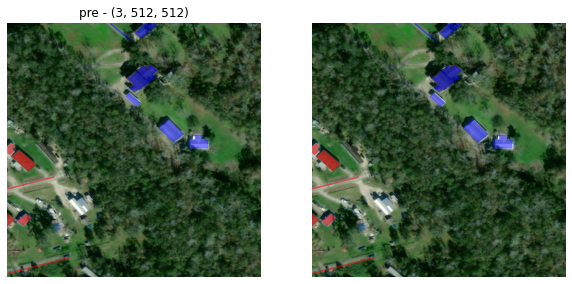

In [418]:
from rasterio.plot import show 
import matplotlib.pyplot as plt
import random 
from geopandas import GeoSeries
from shapely.geometry import LineString, Polygon

img, geom, transform, date, y1, y2 = dm.ds_train[random.randint(0, len(dm.ds_train))]
# img, geom, transform, date, y1, y2 = dm.ds_train[0]

fig = plt.figure(figsize=(10, 20))
ax = plt.subplot(121)
ax.imshow(img.transpose(1,2,0))
# show(img, ax=ax, transform=transform)
flooded = geom[geom.flooded == 'yes']
if len(flooded) > 0:
	flooded.plot(ax=ax, color='blue', alpha=0.5)
no_flooded = geom[geom.flooded != 'yes']
if len(no_flooded) > 0:
	no_flooded.plot(ax=ax, color='red', alpha=0.5)
ax.set_title(f'{date} - {img.shape}')
ax.axis('off')
ax = plt.subplot(122)
ax.imshow(img.transpose(1,2,0))
lines, lines_flooded = [], []
for row in y1:
	if row[0] != -1:
		_lines = []
		for ix in range(0, y1.shape[1], 2):
			y, x = row[ix], row[ix+1]
			if y != -1:					
				_lines.append((y*img.shape[1],x*img.shape[2]))
		if row[-1]:
			lines_flooded.append(_lines)
		else:
			lines.append(_lines)
lines = GeoSeries([LineString(l) for l in lines])
lines.plot(ax=ax, color='red', alpha=0.5)
lines_flooded = GeoSeries([LineString(l) for l in lines_flooded])
lines_flooded.plot(ax=ax, color='blue', alpha=0.5)
polys, polys_flooded = [], []
for row in y2:
	if row[0] != -1:
		_polys = []
		for ix in range(0, y2.shape[1], 2):
			y, x = row[ix], row[ix+1]
			if y != -1:
				_polys.append((y*img.shape[1],x*img.shape[2]))
		_polys.append(_polys[0]) # close with first point
		if row[-1]:
			polys_flooded.append(_polys)
		else:
			polys.append(_polys)
polys = GeoSeries([Polygon(l) for l in polys])
polys.plot(ax=ax, color='red', alpha=0.5)
polys_flooded = GeoSeries([Polygon(l) for l in polys_flooded])
polys_flooded.plot(ax=ax, color='blue', alpha=0.5)
ax.axis('off')
plt.show()

In [404]:
y1

tensor([[ 0.1016,  0.0000,  0.1172,  ..., -1.0000, -1.0000,  0.0000],
        [ 1.0000,  0.3340,  0.4980,  ..., -1.0000, -1.0000,  0.0000],
        [ 0.5254,  1.0000,  0.7188,  ..., -1.0000, -1.0000,  0.0000],
        ...,
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]])

In [405]:
y2

tensor([[ 0.7109,  0.7793,  0.6953,  ..., -1.0000, -1.0000,  0.0000],
        [ 0.5684,  0.8906,  0.5078,  ..., -1.0000, -1.0000,  0.0000],
        [ 0.4062,  1.0000,  0.4062,  ..., -1.0000, -1.0000,  0.0000],
        ...,
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]])